In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage

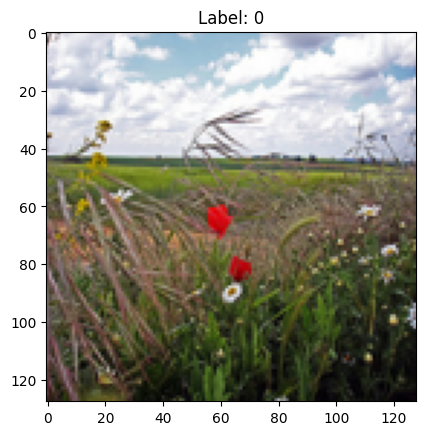

Image shape: (128, 128, 3)
Label: 0


In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

def load_dataset():
    with h5py.File('Tr.h5', "r") as train_dataset:
        train_set_x_orig = np.array(train_dataset["images"][:])
        train_set_y_orig = np.array(train_dataset["labels"][:])

    with h5py.File('Te.h5', "r") as test_dataset:
        test_set_x_orig = np.array(test_dataset["images"][:])
        test_set_y_orig = np.array(test_dataset["labels"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig

train_set_x_orig, train_set_y, test_set_x_orig, test_set_y = load_dataset()

def display_sample(index):
    plt.imshow(train_set_x_orig[index])
    plt.title(f"Label: {train_set_y[:, index][0]}")
    plt.show()
    print(f"Image shape: {train_set_x_orig[index].shape}")
    print(f"Label: {train_set_y[:, index][0]}")
for i in range(1):
    display_sample(i)

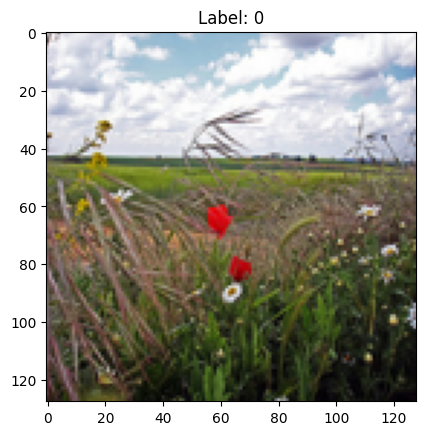

Image shape: (128, 128, 3)
Label: 0


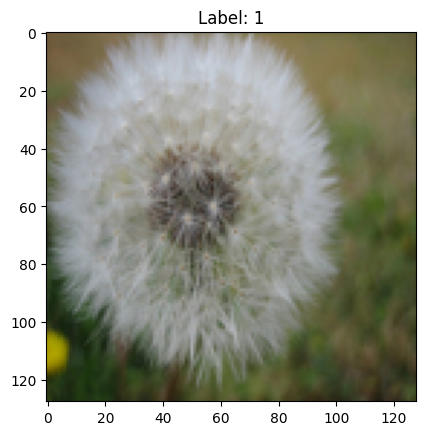

Image shape: (128, 128, 3)
Label: 1


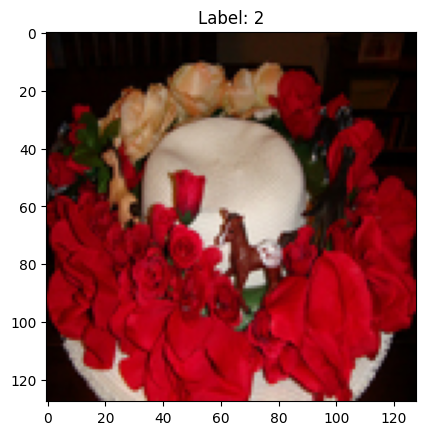

Image shape: (128, 128, 3)
Label: 2


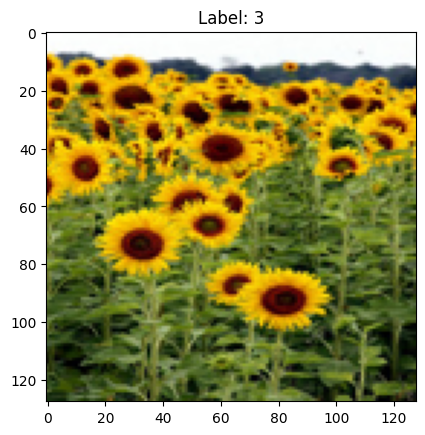

Image shape: (128, 128, 3)
Label: 3


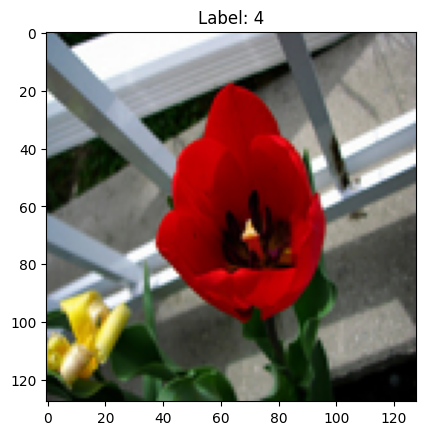

Image shape: (128, 128, 3)
Label: 4


In [2]:
labels = np.unique(train_set_y)
indices = [np.where(train_set_y[0] == label)[0][0] for label in labels]
for index in indices:
    display_sample(index)

In [6]:
m_train = train_set_x_orig.shape[0]
m_test  = test_set_x_orig.shape[0]
num_px  = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 250
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 128
Each image is of size: (128, 128, 3)
train_set_x shape: (250, 128, 128, 3)
train_set_y shape: (1, 250)
test_set_x shape: (50, 128, 128, 3)
test_set_y shape: (1, 50)


In [8]:
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T
print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (49152, 250)
train_set_y shape: (1, 250)
test_set_x_flatten shape: (49152, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [206 208 213 149 135]


In [9]:
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

In [10]:
def initialize_with_zeros(dim, num_classes):
    w = np.zeros((dim, num_classes))
    b = np.zeros((num_classes,))
    return w, b

In [11]:
def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=0, keepdims=True))  # Subtract max for numerical stability
    return exp_z / np.sum(exp_z, axis=0, keepdims=True)

In [12]:
def compute_cost_and_grads(w, b, X, Y):
    m = X.shape[1]
    Z = np.dot(w.T, X) + b[:, np.newaxis]
    A = softmax(Z)
    cost = -np.sum(Y * np.log(A)) / m

    dZ = A - Y
    dw = np.dot(X, dZ.T) / m
    db = np.sum(dZ, axis=1) / m

    grads = {"dw": dw, "db": db}
    return grads, cost

In [13]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost):
    costs = []
    for i in range(num_iterations):
        grads, cost = compute_cost_and_grads(w, b, X, Y)
        dw = grads["dw"]
        db = grads["db"]

        w -= learning_rate * dw
        b -= learning_rate * db

        if i % 100 == 0:
            costs.append(cost)
            if print_cost:
                print(f"Cost after iteration {i}: {cost}")

    parameters = {"w": w, "b": b}
    return parameters, grads, costs

In [14]:
def predict(w, b, X):
    Z = np.dot(w.T, X) + b[:, np.newaxis]
    A = softmax(Z)
    predictions = np.argmax(A, axis=0)
    return predictions

In [15]:
def model(X_train, Y_train, X_test, Y_test, num_classes, num_iterations=2000, learning_rate=0.001, print_cost=False):
    w, b = initialize_with_zeros(X_train.shape[0], num_classes)

    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    w = parameters["w"]
    b = parameters["b"]

    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    train_accuracy = 100 - np.mean(np.argmax(Y_train, axis=0) != Y_prediction_train) * 100
    test_accuracy = 100 - np.mean(np.argmax(Y_test, axis=0) != Y_prediction_test) * 100

    print(f"train accuracy: {train_accuracy} %")
    print(f"test accuracy: {test_accuracy} %")

    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train": Y_prediction_train,
         "w": w,
         "b": b,
         "learning_rate": learning_rate,
         "num_iterations": num_iterations}

    return d

In [16]:
num_features = train_set_x.shape[0]
num_classes = len(np.unique(train_set_y))
train_set_y_one_hot = np.eye(num_classes)[train_set_y.reshape(-1)].T
test_set_y_one_hot = np.eye(num_classes)[test_set_y.reshape(-1)].T

d = model(train_set_x, train_set_y_one_hot, test_set_x, test_set_y_one_hot, num_classes, num_iterations=2000, learning_rate=0.001, print_cost=True)

Cost after iteration 0: 1.6094379124341003
Cost after iteration 100: 0.8183655744011987
Cost after iteration 200: 0.5950472749627373
Cost after iteration 300: 0.46586158334562866
Cost after iteration 400: 0.38034531668013133
Cost after iteration 500: 0.31960945895217696
Cost after iteration 600: 0.27438189062489904
Cost after iteration 700: 0.23950260186439495
Cost after iteration 800: 0.21186599179313403
Cost after iteration 900: 0.1894927484262716
Cost after iteration 1000: 0.171061852521152
Cost after iteration 1100: 0.15565648057001824
Cost after iteration 1200: 0.14261902298692614
Cost after iteration 1300: 0.13146503093853007
Cost after iteration 1400: 0.12182999611277977
Cost after iteration 1500: 0.11343495146971348
Cost after iteration 1600: 0.10606331584924152
Cost after iteration 1700: 0.0995448019697314
Cost after iteration 1800: 0.09374397065894814
Cost after iteration 1900: 0.08855194824375849
train accuracy: 100.0 %
test accuracy: 32.0 %


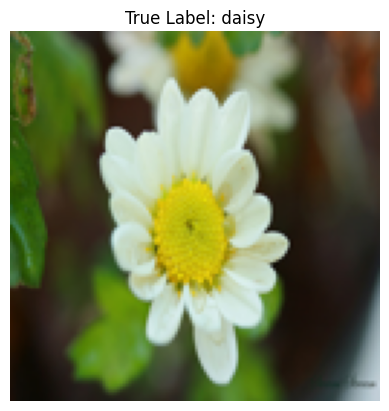

True label: 0 ---> daisy
Predicted label: 1 ---> dandelion


In [19]:
import random
import matplotlib.pyplot as plt
flower_names = {0: 'daisy', 1: 'dandelion', 2: 'roses', 3: 'sunflowers', 4: 'tulips'}

def display_random_test_image():
    index = random.randint(0, test_set_x_orig.shape[0] - 1)
    plt.imshow(test_set_x_orig[index])
    plt.title(f"True Label: {flower_names[test_set_y[:, index][0]]}")
    plt.axis('off')
    plt.show()
    true_label = test_set_y[0, index]
    predicted_index = int(d["Y_prediction_test"][index])
    print(f"True label: {true_label} ---> {flower_names[true_label]}")
    print(f"Predicted label: {predicted_index} ---> {flower_names[predicted_index]}")
display_random_test_image()


learning rate is: 0.01
train accuracy: 0.0 %
test accuracy: 0.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 61.6 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 69.2 %
test accuracy: 72.0 %

-------------------------------------------------------



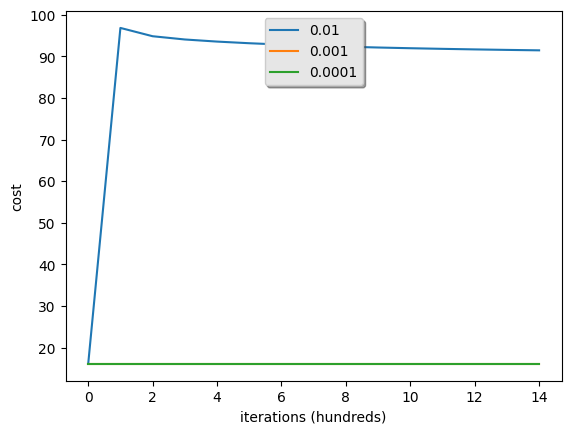

In [20]:
import matplotlib.pyplot as plt

# Assuming you have these variables defined
num_classes = len(np.unique(train_set_y))

learning_rates = [0.01, 0.001, 0.0001]
models = {}

for lr in learning_rates:
    print("learning rate is: " + str(lr))
    models[str(lr)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_classes=num_classes, num_iterations=1500, learning_rate=lr, print_cost=False)
    print('\n' + "-------------------------------------------------------" + '\n')

# Plot the costs
for lr in learning_rates:
    plt.plot(np.squeeze(models[str(lr)]["costs"]), label=str(lr))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()


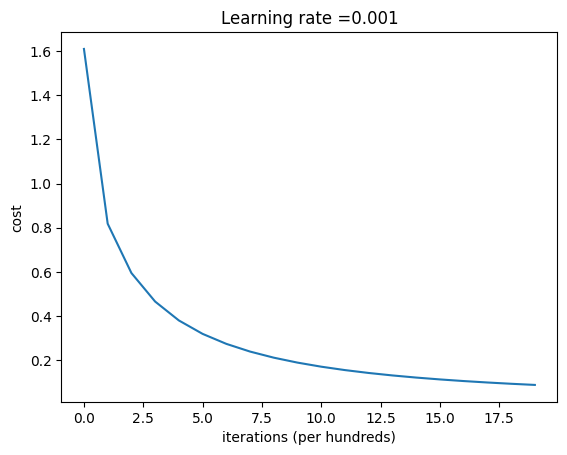

In [21]:
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()